# MSiA 400 - Final Project
## SARIMAX Model
### Team 12: Alejandra Lelo de Larrea Ibarra, Xin Shu, Yi Chen, Yiqing Cheng

In [1]:
import pandas as pd
import psycopg2
from psycopg2 import Error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pmdarima as pm
from pmdarima.arima import ADFTest
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
try:
    # Connect to an existing database
    connection = psycopg2.connect(database="2022-everything-team12", 
                            user='USER', 
                            password='PASS', 
                            host='pg.analytics.northwestern.edu', 
                            port= '5432')

    # Create a cursor to perform database operations
    cursor = connection.cursor()
    # Print PostgreSQL details
    cursor.execute("SELECT version();")
    # Fetch result
    record = cursor.fetchone()
    print("You are connected to - ", record, "\n")
except (Exception, Error) as error:
    print("Error while connecting to PostgreSQL", error)
df = pd.read_sql("select * from \"aggtrnsactdaily2\"", connection);
if (connection):
    cursor.close()
    connection.close()
    print("PostgreSQL connection is closed") 

You are connected to -  ('PostgreSQL 10.12 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-39), 64-bit',) 



/tmp/ipykernel_604065/200907277.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("select * from \"aggtrnsactdaily2\"", connection);


PostgreSQL connection is closed


In [3]:
# data preprocessing

In [4]:
unemployee = pd.read_csv("UNRATE.csv")
cpi = pd.read_csv("cpi.csv")
dff = pd.read_csv("DFF.csv")
df['saledate']= pd.to_datetime(df['saledate'])
cpi['DATE']= pd.to_datetime(cpi['DATE'])
unemployee['DATE']= pd.to_datetime(unemployee['DATE'])
dff['DATE']= pd.to_datetime(dff['DATE'])

df_combined = pd.merge(df.assign(grouper=df['saledate'].dt.to_period('M')),
               cpi.assign(grouper=cpi['DATE'].dt.to_period('M')),
               how='left', on='grouper')
df_combined = pd.merge(df_combined.assign(grouper=df_combined['saledate'].dt.to_period('M')),
               unemployee.assign(grouper=unemployee['DATE'].dt.to_period('M')),
               how='left', on='grouper')
df_combined = pd.merge(df_combined.assign(grouper=df_combined['saledate'].dt.to_period('D')),
               dff.assign(grouper=dff['DATE'].dt.to_period('D')),
               how='left', on='grouper')

df_combined = df_combined.drop(columns = ["grouper","DATE_x","DATE_y","DATE"])

df_combined = df_combined.rename(columns={'CORESTICKM159SFRBATL': 'CPI'})
df_combined



,saledate,nstores,nsku,totalquantity,avgquantity,totalamt,avgamt,minamt,maxamt,totalorigprice,...,minprofit,maxprofit,nstore,ncities,ndept,nvendors,avgvendorsstore,CPI,UNRATE,DFF
0,2004-08-01,323,61741,188073,783,6035654.36,25148.559833,0.0,895.0,4467905.60,...,0.0,275.00,323,262,58,852,2,2.257729,5.4,1.29
1,2004-08-02,324,59183,177143,208,5637192.49,6624.197991,0.0,1200.0,4174584.51,...,0.0,359.00,324,263,58,827,2,2.257729,5.4,1.28
2,2004-08-03,324,62593,212625,233,6569613.74,7219.355758,0.0,895.0,4833202.76,...,0.0,393.00,324,263,58,842,2,2.257729,5.4,1.24
3,2004-08-04,324,65689,218053,241,6874637.33,7604.687312,0.0,895.0,4974026.91,...,0.0,393.00,324,263,58,843,2,2.257729,5.4,1.22
4,2004-08-05,325,68941,225237,289,7913489.50,10184.671171,0.0,1200.0,5501540.60,...,0.0,393.00,325,263,58,870,2,2.257729,5.4,1.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,2005-08-26,324,144548,482390,525,19215591.82,20932.017233,0.0,1200.0,8968694.40,...,0.0,450.00,324,263,60,1056,3,2.264406,4.9,3.54
385,2005-08-27,325,174635,726056,790,29404178.67,31995.841861,0.0,1200.0,14044552.29,...,0.0,555.29,325,264,60,1098,3,2.264406,4.9,3.54
386,2005-02-23,324,154375,818303,739,36239176.72,32736.383668,0.0,1298.0,10507344.52,...,0.0,780.00,324,263,58,1035,3,2.286245,5.4,2.53
387,2005-02-24,324,155570,839153,735,35454568.88,31073.241788,0.0,1200.0,10844948.29,...,0.0,495.00,324,263,58,1059,3,2.286245,5.4,2.55


In [5]:
df.sort_values(by=['saledate'],inplace=True)
df = df.set_index('saledate')
df.index = pd.to_datetime(df.index)
df

,nstores,nsku,totalquantity,avgquantity,totalamt,avgamt,minamt,maxamt,totalorigprice,avgorigprice,...,maxdiscount,totalprofit,avgprofittrnsact,minprofit,maxprofit,nstore,ncities,ndept,nvendors,avgvendorsstore
saledate,,,,,,,,,,,,,,,,,,,,,
2004-08-01,323,61741,188073,783,6035654.36,25148.559833,0.0,895.0,4467905.60,23.756231,...,118.50,511060.0,2129.418229,0.0,275.00,323,262,58,852,2
2004-08-02,324,59183,177143,208,5637192.49,6624.197991,0.0,1200.0,4174584.51,23.566184,...,325.00,532033.0,625.185444,0.0,359.00,324,263,58,827,2
2004-08-03,324,62593,212625,233,6569613.74,7219.355758,0.0,895.0,4833202.76,22.731112,...,119.00,659895.0,725.159066,0.0,393.00,324,263,58,842,2
2004-08-04,324,65689,218053,241,6874637.33,7604.687312,0.0,895.0,4974026.91,22.811091,...,275.00,631430.0,698.484375,0.0,393.00,324,263,58,843,2
2004-08-05,325,68941,225237,289,7913489.50,10184.671171,0.0,1200.0,5501540.60,24.425563,...,275.00,635209.0,817.514640,0.0,393.00,325,263,58,870,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-08-23,325,84999,216712,226,7457004.46,7800.213870,0.0,1200.0,5141321.76,23.724214,...,347.50,1477840.0,1545.861402,0.0,768.75,325,264,60,944,2
2005-08-24,325,140901,466006,496,19248987.11,20521.308220,0.0,1200.0,8398192.33,18.021640,...,476.00,1982620.0,2113.670176,0.0,555.29,325,264,60,1041,3
2005-08-25,325,134977,422296,442,17062480.18,17885.199350,0.0,1200.0,7772270.13,18.404792,...,581.75,1943150.0,2036.842243,0.0,500.00,325,264,60,1019,3


In [6]:
df_combined.sort_values(by=['saledate'],inplace=True)
df_combined = df_combined.set_index('saledate')
df_combined.index = pd.to_datetime(df_combined.index)
df_combined

,nstores,nsku,totalquantity,avgquantity,totalamt,avgamt,minamt,maxamt,totalorigprice,avgorigprice,...,minprofit,maxprofit,nstore,ncities,ndept,nvendors,avgvendorsstore,CPI,UNRATE,DFF
saledate,,,,,,,,,,,,,,,,,,,,,
2004-08-01,323,61741,188073,783,6035654.36,25148.559833,0.0,895.0,4467905.60,23.756231,...,0.0,275.00,323,262,58,852,2,2.257729,5.4,1.29
2004-08-02,324,59183,177143,208,5637192.49,6624.197991,0.0,1200.0,4174584.51,23.566184,...,0.0,359.00,324,263,58,827,2,2.257729,5.4,1.28
2004-08-03,324,62593,212625,233,6569613.74,7219.355758,0.0,895.0,4833202.76,22.731112,...,0.0,393.00,324,263,58,842,2,2.257729,5.4,1.24
2004-08-04,324,65689,218053,241,6874637.33,7604.687312,0.0,895.0,4974026.91,22.811091,...,0.0,393.00,324,263,58,843,2,2.257729,5.4,1.22
2004-08-05,325,68941,225237,289,7913489.50,10184.671171,0.0,1200.0,5501540.60,24.425563,...,0.0,393.00,325,263,58,870,2,2.257729,5.4,1.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-08-23,325,84999,216712,226,7457004.46,7800.213870,0.0,1200.0,5141321.76,23.724214,...,0.0,768.75,325,264,60,944,2,2.264406,4.9,3.49
2005-08-24,325,140901,466006,496,19248987.11,20521.308220,0.0,1200.0,8398192.33,18.021640,...,0.0,555.29,325,264,60,1041,3,2.264406,4.9,3.50
2005-08-25,325,134977,422296,442,17062480.18,17885.199350,0.0,1200.0,7772270.13,18.404792,...,0.0,500.00,325,264,60,1019,3,2.264406,4.9,3.55


In [7]:
# # normalize data for feature selection

# df_viz = df
# from sklearn.preprocessing import MinMaxScaler
# mc = MinMaxScaler()
# mc.fit(df_viz)
# minMax = mc.transform(df_viz)
# x_minmax = pd.DataFrame(minMax, columns = list(df_viz.columns))#.remove('totalprofit'))
# x_minmax.index = df_viz.index


# for i in list(x_minmax.columns):
#     fig, ax = plt.subplots(figsize=(15, 5))

# #     plt.figure()
#     plt.plot(x_minmax[i])
#     plt.plot(x_minmax.totalprofit)
#     plt.legend([i,'total profit'])
    
#     plt.show()
    

In [8]:
original_features = df.columns
original_features.drop('totalprofit')
original_features

Index(['nstores', 'nsku', 'totalquantity', 'avgquantity', 'totalamt', 'avgamt',
       'minamt', 'maxamt', 'totalorigprice', 'avgorigprice', 'minorigprice',
       'maxorigprice', 'totalretail', 'avgretail', 'minretail', 'maxretail',
       'avgretailtrnsact', 'totalcost', 'avgcost', 'mincost', 'maxcost',
       'avgcosttrnsact', 'totaldiscount', 'avgdiscounttrnsact', 'mindiscount',
       'maxdiscount', 'totalprofit', 'avgprofittrnsact', 'minprofit',
       'maxprofit', 'nstore', 'ncities', 'ndept', 'nvendors',
       'avgvendorsstore'],
      dtype='object')

In [9]:
# TODO: add lags
lag_list = []
def create_lag_feature(df, column):
    '''
    Create time lagging features
    '''
#     df = df.copy()
    average_value = np.mean(df[column])
    df[column + '_1'] = df[column].shift(1,fill_value = average_value)
    df[column + '_2'] = df[column].shift(2,fill_value = average_value)
    df[column + '_3'] = df[column].shift(3,fill_value = average_value)
    df[column + '_4'] = df[column].shift(4,fill_value = average_value)
    df[column + '_5'] = df[column].shift(5,fill_value = average_value)
    df[column + '_6'] = df[column].shift(6,fill_value = average_value)
    df[column + '_7'] = df[column].shift(7,fill_value = average_value)
    df[column + '_14'] = df[column].shift(14,fill_value = average_value)
    df[column + '_28'] = df[column].shift(28,fill_value = average_value)
    lag_list.append(column + '_1')
    lag_list.append(column + '_2')
    lag_list.append(column + '_3')
    lag_list.append(column + '_4')
    lag_list.append(column + '_5')
    lag_list.append(column + '_6')
    lag_list.append(column + '_7')
    lag_list.append(column + '_14')
    lag_list.append(column + '_28')

    return df

df_lag = df.copy()
for col in original_features:
    create_lag_feature(df_lag, col)
    
df_lag.drop(original_features, axis=1, inplace=True)


/tmp/ipykernel_604065/2272398931.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column + '_28'] = df[column].shift(28,fill_value = average_value)
/tmp/ipykernel_604065/2272398931.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column + '_1'] = df[column].shift(1,fill_value = average_value)
/tmp/ipykernel_604065/2272398931.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once usi

In [10]:
df_lag.head(5)


,nstores_1,nstores_2,nstores_3,nstores_4,nstores_5,nstores_6,nstores_7,nstores_14,nstores_28,nsku_1,...,nvendors_28,avgvendorsstore_1,avgvendorsstore_2,avgvendorsstore_3,avgvendorsstore_4,avgvendorsstore_5,avgvendorsstore_6,avgvendorsstore_7,avgvendorsstore_14,avgvendorsstore_28
saledate,,,,,,,,,,,,,,,,,,,,,
2004-08-01,323.701799,323.701799,323.701799,323.701799,323.701799,323.701799,323.701799,323.701799,323.701799,89270.339332,...,931.768638,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933
2004-08-02,323.000000,323.701799,323.701799,323.701799,323.701799,323.701799,323.701799,323.701799,323.701799,61741.000000,...,931.768638,2.000000,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933
2004-08-03,324.000000,323.000000,323.701799,323.701799,323.701799,323.701799,323.701799,323.701799,323.701799,59183.000000,...,931.768638,2.000000,2.000000,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933
2004-08-04,324.000000,324.000000,323.000000,323.701799,323.701799,323.701799,323.701799,323.701799,323.701799,62593.000000,...,931.768638,2.000000,2.000000,2.000000,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933
2004-08-05,324.000000,324.000000,324.000000,323.000000,323.701799,323.701799,323.701799,323.701799,323.701799,65689.000000,...,931.768638,2.000000,2.000000,2.000000,2.000000,2.233933,2.233933,2.233933,2.233933,2.233933


In [11]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofmonth'] = df.index.day
    return df
# create time series features
df_lag_ts = create_features(df_lag)


In [12]:
df_lag_ts.head()

,nstores_1,nstores_2,nstores_3,nstores_4,nstores_5,nstores_6,nstores_7,nstores_14,nstores_28,nsku_1,...,avgvendorsstore_6,avgvendorsstore_7,avgvendorsstore_14,avgvendorsstore_28,hour,dayofweek,quarter,month,year,dayofmonth
saledate,,,,,,,,,,,,,,,,,,,,,
2004-08-01,323.701799,323.701799,323.701799,323.701799,323.701799,323.701799,323.701799,323.701799,323.701799,89270.339332,...,2.233933,2.233933,2.233933,2.233933,0,6,3,8,2004,1
2004-08-02,323.000000,323.701799,323.701799,323.701799,323.701799,323.701799,323.701799,323.701799,323.701799,61741.000000,...,2.233933,2.233933,2.233933,2.233933,0,0,3,8,2004,2
2004-08-03,324.000000,323.000000,323.701799,323.701799,323.701799,323.701799,323.701799,323.701799,323.701799,59183.000000,...,2.233933,2.233933,2.233933,2.233933,0,1,3,8,2004,3
2004-08-04,324.000000,324.000000,323.000000,323.701799,323.701799,323.701799,323.701799,323.701799,323.701799,62593.000000,...,2.233933,2.233933,2.233933,2.233933,0,2,3,8,2004,4
2004-08-05,324.000000,324.000000,324.000000,323.000000,323.701799,323.701799,323.701799,323.701799,323.701799,65689.000000,...,2.233933,2.233933,2.233933,2.233933,0,3,3,8,2004,5


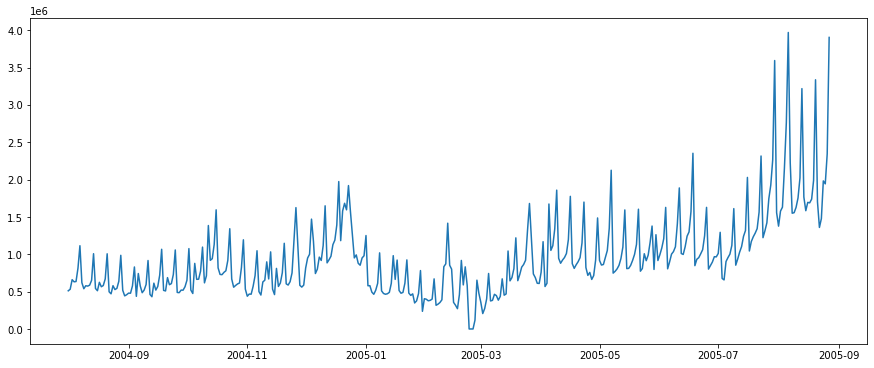

In [13]:
#visualize total profit
fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(df.totalprofit)
plt.show()


In [14]:
df_lag_ts = df_lag_ts.join(df_combined[['CPI','UNRATE','DFF']])

In [15]:
#normalize x variables
from sklearn.preprocessing import MinMaxScaler
mc = MinMaxScaler()
mc.fit(df_lag_ts)
minMax = mc.transform(df_lag_ts)
x_minmax = pd.DataFrame(minMax, columns = list(df_lag_ts.columns))
x_minmax.index = df_lag_ts.index

df_norm = x_minmax.join(pd.DataFrame(df_combined['totalprofit']))
df_norm


,nstores_1,nstores_2,nstores_3,nstores_4,nstores_5,nstores_6,nstores_7,nstores_14,nstores_28,nsku_1,...,hour,dayofweek,quarter,month,year,dayofmonth,CPI,UNRATE,DFF,totalprofit
saledate,,,,,,,,,,,,,,,,,,,,,
2004-08-01,0.877194,0.877194,0.877194,0.877194,0.877194,0.877194,0.877194,0.877194,0.877194,0.299374,...,0.0,1.000000,0.666667,0.636364,0.0,0.000000,0.368058,0.833333,0.037344,511060.0
2004-08-02,0.857143,0.877194,0.877194,0.877194,0.877194,0.877194,0.877194,0.877194,0.877194,0.093604,...,0.0,0.000000,0.666667,0.636364,0.0,0.033333,0.368058,0.833333,0.033195,532033.0
2004-08-03,0.885714,0.857143,0.877194,0.877194,0.877194,0.877194,0.877194,0.877194,0.877194,0.074484,...,0.0,0.166667,0.666667,0.636364,0.0,0.066667,0.368058,0.833333,0.016598,659895.0
2004-08-04,0.885714,0.885714,0.857143,0.877194,0.877194,0.877194,0.877194,0.877194,0.877194,0.099972,...,0.0,0.333333,0.666667,0.636364,0.0,0.100000,0.368058,0.833333,0.008299,631430.0
2004-08-05,0.885714,0.885714,0.885714,0.857143,0.877194,0.877194,0.877194,0.877194,0.877194,0.123114,...,0.0,0.500000,0.666667,0.636364,0.0,0.133333,0.368058,0.833333,0.041494,635209.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-08-23,0.914286,0.914286,0.914286,0.914286,0.914286,0.914286,0.914286,0.914286,0.885714,0.271252,...,0.0,0.166667,0.666667,0.636364,1.0,0.733333,0.410156,0.000000,0.950207,1477840.0
2005-08-24,0.914286,0.914286,0.914286,0.914286,0.914286,0.914286,0.914286,0.914286,0.885714,0.267448,...,0.0,0.333333,0.666667,0.636364,1.0,0.766667,0.410156,0.000000,0.954357,1982620.0
2005-08-25,0.914286,0.914286,0.914286,0.914286,0.914286,0.914286,0.914286,0.914286,0.885714,0.685291,...,0.0,0.500000,0.666667,0.636364,1.0,0.800000,0.410156,0.000000,0.975104,1943150.0


In [25]:
from scipy.stats import pearsonr

df_pearson = pd.DataFrame()
name_list = []
coef_list = []

for i in df_norm.columns:
    pearson_coef = pearsonr(df_norm[i], df_norm['totalprofit'])
    name_list.append(i)
    coef_list.append(pearson_coef[0])
    
df_pearson[' '] = name_list
df_pearson['Coef'] = coef_list

df_pearson = df_pearson.dropna()
df_pearson = df_pearson.sort_values(by='Coef', ascending=False)

df_pearson = df_pearson.set_index(' ')
# df_pearson.index = df_pearson.to_datetime(df_pearson.index)

df_pearson.head(10)


/nfs/home/xst2267/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


,Coef
,
totalprofit,1.000000
totalprofit_7,0.842549
avgprofittrnsact_6,0.784076
totalprofit_14,0.722531
totalprofit_1,0.702355
totalretail_7,0.701934
avgretailtrnsact_6,0.671608
totalretail_14,0.629148
totalprofit_6,0.607038


In [17]:
#split train and test data
train = df_norm[(df_norm.index.get_level_values(0) >= '2004-08-01') & (df_norm.index.get_level_values(0) < '2005-06-01')]
test = df_norm[(df_norm.index.get_level_values(0) >= '2005-06-01') & (df_norm.index.get_level_values(0) < '2005-08-01')]


In [18]:
test 

,nstores_1,nstores_2,nstores_3,nstores_4,nstores_5,nstores_6,nstores_7,nstores_14,nstores_28,nsku_1,...,hour,dayofweek,quarter,month,year,dayofmonth,CPI,UNRATE,DFF,totalprofit
saledate,,,,,,,,,,,,,,,,,,,,,
2005-06-01,0.885714,0.885714,0.857143,0.885714,0.885714,0.885714,0.885714,0.885714,0.885714,0.206156,...,0.0,0.333333,0.333333,0.454545,1.0,0.000000,0.000000,0.166667,0.755187,993452.0
2005-06-02,0.885714,0.885714,0.885714,0.857143,0.885714,0.885714,0.885714,0.885714,0.885714,0.243327,...,0.0,0.500000,0.333333,0.454545,1.0,0.033333,0.000000,0.166667,0.746888,1084340.0
2005-06-03,0.885714,0.885714,0.885714,0.885714,0.857143,0.885714,0.885714,0.885714,0.885714,0.286709,...,0.0,0.666667,0.333333,0.454545,1.0,0.066667,0.000000,0.166667,0.742739,1208760.0
2005-06-04,0.885714,0.885714,0.885714,0.885714,0.885714,0.857143,0.885714,0.885714,0.885714,0.341805,...,0.0,0.833333,0.333333,0.454545,1.0,0.100000,0.000000,0.166667,0.742739,1627830.0
2005-06-05,0.885714,0.885714,0.885714,0.885714,0.885714,0.885714,0.857143,0.857143,0.885714,0.484427,...,0.0,1.000000,0.333333,0.454545,1.0,0.133333,0.000000,0.166667,0.742739,805507.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-07-27,0.885714,0.885714,0.885714,0.885714,0.885714,0.885714,0.885714,0.885714,0.885714,0.318469,...,0.0,0.333333,0.666667,0.545455,1.0,0.866667,0.641388,0.166667,0.858921,1744320.0
2005-07-28,0.885714,0.885714,0.885714,0.885714,0.885714,0.885714,0.885714,0.885714,0.885714,0.750103,...,0.0,0.500000,0.666667,0.545455,1.0,0.900000,0.641388,0.166667,0.858921,1927240.0
2005-07-29,0.885714,0.885714,0.885714,0.885714,0.885714,0.885714,0.885714,0.885714,0.885714,0.733345,...,0.0,0.666667,0.666667,0.545455,1.0,0.933333,0.641388,0.166667,0.875519,2265910.0


### Initialize the auto arima function


In [19]:
import pmdarima as pm

# SARIMAX Model
# input x exogenous variables with lag 1 because they show correlation with total profit.

exovars = ['totalprofit_7', 'avgprofittrnsact_6', 'totalprofit_14', 'totalprofit_1', 'totalretail_7']
sxmodel = pm.auto_arima(train[['totalprofit']], exogenous=train[exovars],
                           start_p=1, start_q=1, start_d=1,
                           test='adf',
                           max_p=5, max_q=5, max_d=5,
                           max_P=5, max_Q=5, max_D=5,
                           m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=8192.953, Time=0.27 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=8377.991, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=8266.847, Time=0.20 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.20 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=8191.777, Time=0.37 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=8229.426, Time=0.29 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=8193.619, Time=1.03 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=8193.368, Time=2.00 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=8191.501, Time=0.99 sec
 ARIMA(1,1,1)(0,1,3)[12]             : AIC=8193.403, Time=1.84 sec
 ARIMA(1,1,1)(1,1,3)[12]             : AIC=8195.373, Time=2.77 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=8196.569, Time=0.66 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=8218.411, Time=0.64 sec
 ARIMA(2,1,1)(0,1,2)[12]     

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  301
Model:             SARIMAX(3, 1, 2)x(1, 1, 2, 12)   Log Likelihood               -4062.675
Date:                            Fri, 09 Dec 2022   AIC                           8143.351
Time:                                    09:28:09   BIC                           8176.317
Sample:                                         0   HQIC                          8156.562
                                            - 301                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7346      0.348      2.113      0.035       0.053       1.416
ar.L2         -0.2630      0.221     -1.190      0.234      -0.696       0.170
ar.L3         -0.2950      0.165     -1.783      0.075      -0.619       0.029
ma.L1         -1.2838      0.349     -3.684      0.000      -1.967      -0.601
ma.L2          0.5661      0.297      1.906      0.057      -0.016       1.148
ar.S.L12      -0.7019      0.364     -1.928      0.054      -1.415       0.012
ma.S.L12      -0.3695      0.412     -0.897      0.370      -1.177       0.438
ma.S.L24      -0.4277      0.405     -1.056      0.291      -1.222       0.366
sigma2      1.686e+11   2.18e-12   7.74e+22      0.000    1.69e+11    1.69e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.45   Jarque-Bera (JB):                46.11
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):               1.93   Skew:                             0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.14e+38. Standard errors may be unstable.
"""

### Fitting the SARIMAX model

In [20]:
sxmodel.fit(train['totalprofit'],X=train[exovars])

ARIMA(order=(3, 1, 2), scoring_args={}, seasonal_order=(1, 1, 2, 12),
      suppress_warnings=True, with_intercept=False)

### Using the SARIMAX model to make predictions

In [21]:
forecast = sxmodel.predict(n_periods=61, return_conf_int=True, X=test[exovars])
forecast_df = pd.DataFrame(forecast[0],columns=['Prediction'])
forecast_df['saledate'] = test.index
forecast_df = forecast_df.set_index('saledate')

forecast


/nfs/home/xst2267/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


(301    8.648146e+05
 302    9.168585e+05
 303    1.082052e+06
 304    1.529164e+06
 305    9.427572e+05
            ...     
 357    1.113722e+06
 358    1.278229e+06
 359    2.146776e+06
 360    2.175921e+06
 361    8.081488e+05
 Length: 61, dtype: float64,
 array([[ 2.72309563e+05,  1.45731960e+06],
        [ 1.83981010e+05,  1.64973599e+06],
        [ 3.01156330e+05,  1.86294766e+06],
        [ 7.06929244e+05,  2.35139957e+06],
        [ 1.00700340e+05,  1.78481400e+06],
        [ 1.58772032e+05,  1.87981275e+06],
        [ 9.53989523e+04,  1.84078063e+06],
        [ 1.87157831e+05,  1.95592363e+06],
        [ 1.49223185e+05,  1.93694721e+06],
        [ 2.81259584e+05,  2.08750092e+06],
        [ 8.62482943e+05,  2.68548149e+06],
        [-1.02099899e+05,  1.73739272e+06],
        [-2.41651401e+03,  1.86128670e+06],
        [-6.20769873e+04,  1.82301993e+06],
        [-1.46535291e+04,  1.88901085e+06],
        [ 1.20135954e+05,  2.04200334e+06],
        [ 3.49223159e+05,  2.2880079

### Plotting the Pandas data frame

In [22]:
import matplotlib.pyplot as plt

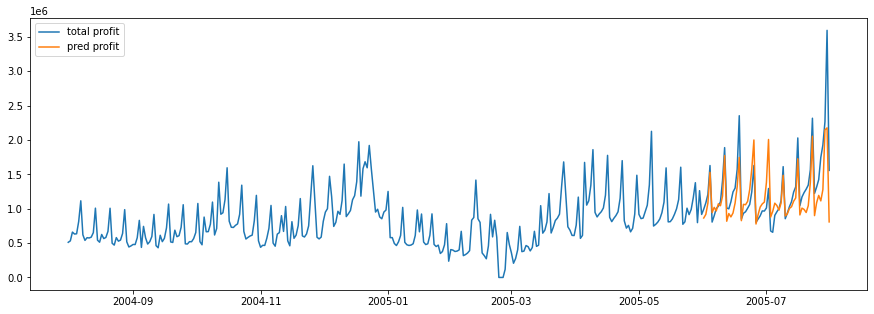

In [23]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(df_norm[df_norm.index.get_level_values(0) < '2005-08-01']['totalprofit'])
plt.plot(forecast_df)
plt.legend(['total profit','pred profit'])
plt.show()
    
# pd.concat([df_ts['totalprofit'],forecast_df],axis=1).plot()

### model evaluation

In [24]:
import sklearn.metrics as metrics
def arima_results(y_true, y_pred):
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [25]:
y_test = test['totalprofit']
y_pred = forecast_df['Prediction']
arima_results(y_test, y_pred)


explained_variance:  0.6103
r2:  0.5716
MAE:  223058.2842
MSE:  102134626309.4651
RMSE:  319585.0846


### data retraining

In [26]:
#split train and test data
new_train = df_norm[(df_norm.index.get_level_values(0) >= '2004-08-01') & (df_norm.index.get_level_values(0) < '2005-08-01')]
new_test = df_norm[df_norm.index.get_level_values(0) >= '2005-08-01']


In [27]:
import pmdarima as pm

# SARIMAX Model
# input x exogenous variables with lag 1 because they show correlation with total profit.

exovars = ['totalprofit_7','avgprofittrnsact_6', 'totalprofit_14', 'totalprofit_1', 'totalretail_7']
sxmodel = pm.auto_arima(new_train[['totalprofit']], exogenous=new_train[exovars],
                           start_p=0, start_q=0, start_d=0,
                           start_P=0, start_Q=0, start_D=0,
                           test='adf',
                           max_p=5, max_q=5, max_d=5,
                           max_P=5, max_Q=5, max_D=5,
                           m=12,
                           seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=10164.057, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=10023.447, Time=0.19 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=10164.534, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=10108.393, Time=0.05 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=10011.631, Time=0.65 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=9996.592, Time=1.27 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=9991.624, Time=2.17 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=9993.207, Time=6.88 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=9980.843, Time=5.13 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=9979.178, Time=2.18 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=9981.224, Time=1.20 sec
 ARIMA(1,0,0)(3,1,2)[12] intercept   : AIC=9979.262, Time=3.60 sec
 ARIMA(1,0,0)(2,1,2)[12] intercept   : AIC=inf, Time=1.49 sec
 ARIMA(1,0,0)(4,1,2)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  362
Model:             SARIMAX(5, 0, 2)x(2, 1, [1], 12)   Log Likelihood               -4932.259
Date:                              Fri, 09 Dec 2022   AIC                           9888.519
Time:                                      09:36:18   BIC                           9934.814
Sample:                                           0   HQIC                          9906.946
                                              - 362                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.832e+04   2.62e+04      0.699      0.485   -3.31e+04    6.97e+04
ar.L1         -0.9634      0.144     -6.712      0.000      -1.245      -0.682
ar.L2          0.1445      0.134      1.081      0.279      -0.117       0.406
ar.L3          0.5760      0.175      3.287      0.001       0.233       0.919
ar.L4          0.3395      0.184      1.844      0.065      -0.021       0.700
ar.L5          0.3719      0.118      3.155      0.002       0.141       0.603
ma.L1          1.5898      0.116     13.689      0.000       1.362       1.817
ma.L2          0.7676      0.103      7.486      0.000       0.567       0.969
ar.S.L12      -0.3502      0.136     -2.582      0.010      -0.616      -0.084
ar.S.L24      -0.1822      0.153     -1.191      0.234      -0.482       0.118
ma.S.L12      -0.8432      0.093     -9.042      0.000      -1.026      -0.660
sigma2      1.582e+11      0.002   8.04e+13      0.000    1.58e+11    1.58e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):                12.94
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               2.21   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.4e+34. Standard errors may be unstable.
"""

In [32]:
sxmodel.fit(new_train['totalprofit'],X=new_train[exovars])

ARIMA(order=(5, 0, 2), scoring_args={}, seasonal_order=(2, 1, 1, 12),
      suppress_warnings=True)

In [38]:
forecast = sxmodel.predict(n_periods=27, return_conf_int=True, X=new_test[exovars])
forecast_df = pd.DataFrame(forecast[0],columns=['Prediction'])
forecast_df['saledate'] = new_test.index
forecast_df = forecast_df.set_index('saledate')

forecast


/nfs/home/xst2267/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


(362    1.394131e+06
 363    1.449904e+06
 364    1.522988e+06
 365    1.711892e+06
 366    2.032952e+06
 367    2.699082e+06
 368    1.848049e+06
 369    1.557606e+06
 370    1.348940e+06
 371    1.394943e+06
 372    1.781739e+06
 373    1.948450e+06
 374    2.896007e+06
 375    1.755935e+06
 376    1.509946e+06
 377    1.303943e+06
 378    1.403311e+06
 379    1.625764e+06
 380    1.648217e+06
 381    2.519736e+06
 382    1.738033e+06
 383    1.457511e+06
 384    1.482609e+06
 385    1.260580e+06
 386    1.675365e+06
 387    1.912957e+06
 388    3.077669e+06
 dtype: float64,
 array([[ 790158.32156826, 1998104.03663983],
        [ 821258.45076249, 2078549.42783993],
        [ 884823.03048496, 2161153.01082669],
        [1054381.35737649, 2369402.59505888],
        [1370617.76209462, 2695285.60079007],
        [2030208.65657738, 3367954.82401452],
        [1178953.22172089, 2517145.00142865],
        [ 883961.81831936, 2231250.99622059],
        [ 675289.22774975, 2022590.05778075],
  

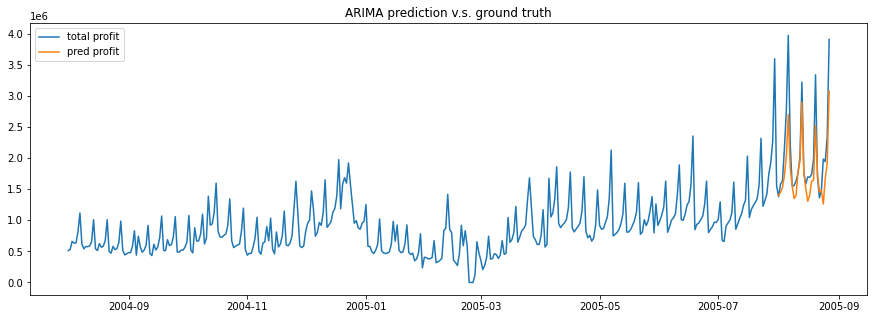

In [39]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(df_norm['totalprofit'])
plt.plot(forecast_df)
plt.legend(['total profit','pred profit'])
# plt.title('ARIMA prediction v.s. ground truth')
plt.show()

In [41]:
import sklearn.metrics as metrics
def arima_results(y_true, y_pred):
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    
y_test = new_test['totalprofit']
y_pred = forecast_df['Prediction']
arima_results(y_test, y_pred)


explained_variance:  0.7947
r2:  0.626
MAE:  309516.7039
MSE:  193542369379.6164
RMSE:  439934.5058


In [43]:
sum(forecast[0])

47958258.81732269